In [1]:
!pip install pandas==1.2.3 seaborn imbalanced_learn

     ---------------------------------------- 9.3/9.3 MB 23.8 MB/s eta 0:00:00
     ---------------------------------------- 226.0/226.0 kB ? eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.0
    Uninstalling pandas-1.5.0:
      Successfully uninstalled pandas-1.5.0



[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

DATASET_PATH = "../../../CE888-2023/lab3-modelling/bank-additional-full.csv"

# Tidy Data

In [3]:
dataset = pd.read_csv(DATASET_PATH, sep=";")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The output above shows that the dataset have `21` features (`11 categorical`,`10 numerical`).

It also shows that there is `no null values`.

# Exploratory Analysis

First let's check the distribution of the target `y`.

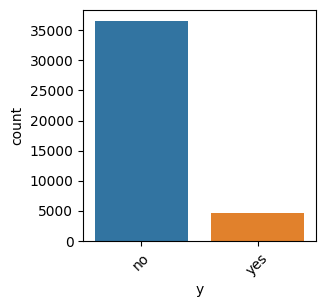

In [52]:
fig = plt.figure(figsize=(3, 3))
sns.countplot(dataset, x='y');
plt.xticks(rotation=45)
plt.show()

There is a huge class imbalance between the class `no` and the class `yes`.

In [193]:
proc_df = dataset.copy() # to ensure that we the original dataset is not affected.

# one hot the categorical features
proc_df = pd.get_dummies(
    proc_df,
    columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
)

# month and day of week has order, therefore we perform ordinal encoding
proc_df['month'] = proc_df['month'].map({
    'mar': 0,
    'apr': 1,
    'may': 2,
    'jun': 3,
    'jul': 4,
    'aug': 5,
    'sep': 6,
    'oct': 7,
    'nov': 8,
    'dec': 9
})

proc_df['day_of_week'] = proc_df['day_of_week'].map({
    'mon': 0,
    'tue': 1,
    'wed': 2,
    'thu': 3,
    'fri': 4
})

# remove the duration column
proc_df = proc_df.drop('duration', axis=1)

# label encode the target
proc_df['y'] = LabelEncoder().fit_transform(proc_df['y'])

columns = ['y'] + [col for col in proc_df.columns.tolist() if col != 'y']
proc_df = proc_df[columns]

proc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   y                              41188 non-null  int32  
 1   age                            41188 non-null  int64  
 2   month                          41188 non-null  int64  
 3   day_of_week                    41188 non-null  int64  
 4   campaign                       41188 non-null  int64  
 5   pdays                          41188 non-null  int64  
 6   previous                       41188 non-null  int64  
 7   emp.var.rate                   41188 non-null  float64
 8   cons.price.idx                 41188 non-null  float64
 9   cons.conf.idx                  41188 non-null  float64
 10  euribor3m                      41188 non-null  float64
 11  nr.employed                    41188 non-null  float64
 12  job_admin.                     41188 non-null 

# Modelling

In [194]:
X, y = SMOTE().fit_resample(proc_df.drop('y', axis=1), proc_df['y'])

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=60)

In [196]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

f1_score(clf.predict(X_test), y_test)

0.9099789702191168

In [197]:
import pickle as pkl

outp = open('model.pkl', 'wb')
pkl.dump(clf, outp, -1)  # where clf is your classifier
outp.close()

In [199]:
pd.concat([X_test, y_test], axis=1).to_csv("testset.csv", index=False)